Imports and Setup

In [1]:
"""
Exploratory Data Analysis - Chest X-Ray Dataset
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import cv2
from collections import Counter

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports successful!")

✅ Imports successful!


 Load Dataset Paths

### Load Chest X-Ray Images

- Load all image paths from `train`, `test`, and `val` folders.  
- Each image is labeled as `NORMAL` or `PNEUMONIA`.  
- Store paths, labels, and split info in a single DataFrame `df`.  
- `df` can be used for EDA, visualization, and model training.

path	label	split

../data/raw/chest_xray/train/NORMAL/IM-0001.jpeg	NORMAL	train

../data/raw/chest_xray/test/PNEUMONIA/IM-0004.jpeg	PNEUMONIA	test

../data/raw/chest_xray/val/NORMAL/IM-0005.jpeg	NORMAL	val

In [3]:
"""
Load all image paths and labels
"""

# Dataset path
data_dir = Path("../data/raw/chest_xray")

# Function to get all image paths
def get_image_paths(split):
    """Get all image paths for a given split"""
    split_path = data_dir / split
    
    normal_images = list((split_path / 'NORMAL').glob('*.jpeg'))
    pneumonia_images = list((split_path / 'PNEUMONIA').glob('*.jpeg'))
    
    # Create dataframe
    data = []
    for img_path in normal_images:
        data.append({'path': str(img_path), 'label': 'NORMAL', 'split': split})
    
    for img_path in pneumonia_images:
        data.append({'path': str(img_path), 'label': 'PNEUMONIA', 'split': split})
    
    return pd.DataFrame(data)

# Load all splits
train_df = get_image_paths('train')
test_df = get_image_paths('test')
val_df = get_image_paths('val')

# Combine
df = pd.concat([train_df, test_df, val_df], ignore_index=True)

print(f"✅ Total images loaded: {len(df):,}")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

✅ Total images loaded: 5,856

Dataset shape: (5856, 3)

First few rows:
                                                path   label  split
0  ..\data\raw\chest_xray\train\NORMAL\IM-0115-00...  NORMAL  train
1  ..\data\raw\chest_xray\train\NORMAL\IM-0117-00...  NORMAL  train
2  ..\data\raw\chest_xray\train\NORMAL\IM-0119-00...  NORMAL  train
3  ..\data\raw\chest_xray\train\NORMAL\IM-0122-00...  NORMAL  train
4  ..\data\raw\chest_xray\train\NORMAL\IM-0125-00...  NORMAL  train


Class Distribution Analysis

### Analyze Class Distribution

- Count number of NORMAL and PNEUMONIA images overall and per split (`train`, `test`, `val`).  
- Compute imbalance ratio.  
- Visualize counts with bar charts and save to `results/plots/class_distribution.png`.  
- Helps identify class imbalance for preprocessing and modeling.


OVERALL CLASS DISTRIBUTION

label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

Total images: 5,856
Normal: 1,583 (27.0%)
Pneumonia: 4,273 (73.0%)
Imbalance ratio: 2.70:1

PER-SPLIT DISTRIBUTION

TRAIN:
  Normal:    1,341
  Pneumonia: 3,875
  Total:     5,216

TEST:
  Normal:    234
  Pneumonia: 390
  Total:     624

VAL:
  Normal:    8
  Pneumonia: 8
  Total:     16


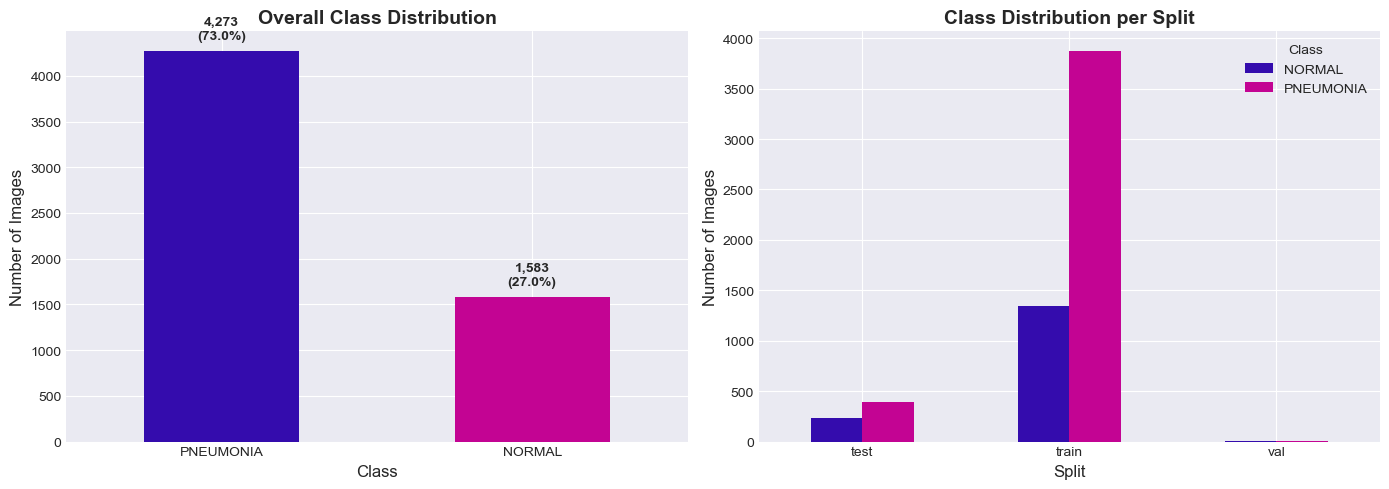


✅ Plots saved to results/plots/


In [6]:
"""
Analyze class distribution
"""

# Overall distribution
print("="*60)
print("OVERALL CLASS DISTRIBUTION")
print("="*60)

class_counts = df['label'].value_counts()
print(f"\n{class_counts}")
print(f"\nTotal images: {len(df):,}")
print(f"Normal: {class_counts['NORMAL']:,} ({class_counts['NORMAL']/len(df)*100:.1f}%)")
print(f"Pneumonia: {class_counts['PNEUMONIA']:,} ({class_counts['PNEUMONIA']/len(df)*100:.1f}%)")
print(f"Imbalance ratio: {class_counts['PNEUMONIA']/class_counts['NORMAL']:.2f}:1")

# Per-split distribution
print("\n" + "="*60)
print("PER-SPLIT DISTRIBUTION")
print("="*60)

for split in ['train', 'test', 'val']:
    split_df = df[df['split'] == split]
    counts = split_df['label'].value_counts()
    print(f"\n{split.upper()}:")
    print(f"  Normal:    {counts.get('NORMAL', 0):,}")
    print(f"  Pneumonia: {counts.get('PNEUMONIA', 0):,}")
    print(f"  Total:     {len(split_df):,}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
ax1 = axes[0]
class_counts.plot(kind='bar', ax=ax1, color=["#340cad", "#c30493"])
ax1.set_title('Overall Class Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

for i, v in enumerate(class_counts):
    ax1.text(i, v + 100, f'{v:,}\n({v/len(df)*100:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')

# Per-split distribution
ax2 = axes[1]
split_counts = df.groupby(['split', 'label']).size().unstack()
split_counts.plot(kind='bar', ax=ax2, color=["#340cad", "#c30493"])
ax2.set_title('Class Distribution per Split', fontsize=14, fontweight='bold')
ax2.set_xlabel('Split', fontsize=12)
ax2.set_ylabel('Number of Images', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.legend(title='Class', loc='upper right')

plt.tight_layout()
plt.savefig('../results/plots/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Plots saved to results/plots/")

# Image Dimension Analysis



- Sample 500 images from the dataset for faster analysis.  
- Compute width and height statistics: min, max, mean, median, std.  
- Identify most common image sizes.  
- Visualize distributions of widths and heights with histograms.  
- Helps determine target size for model input and detect outliers.


IMAGE DIMENSION ANALYSIS

Analyzing sample of 500 images...

Width statistics:
  Min: 437
  Max: 2694
  Mean: 1325.2
  Median: 1296.0
  Std: 348.4

Height statistics:
  Min: 132
  Max: 2625
  Mean: 971.8
  Median: 904.0
  Std: 374.3

Most common dimensions:
  1328×888: 2 images (0.4%)
  1336×1056: 2 images (0.4%)
  1192×760: 2 images (0.4%)
  976×608: 2 images (0.4%)
  920×680: 1 images (0.2%)


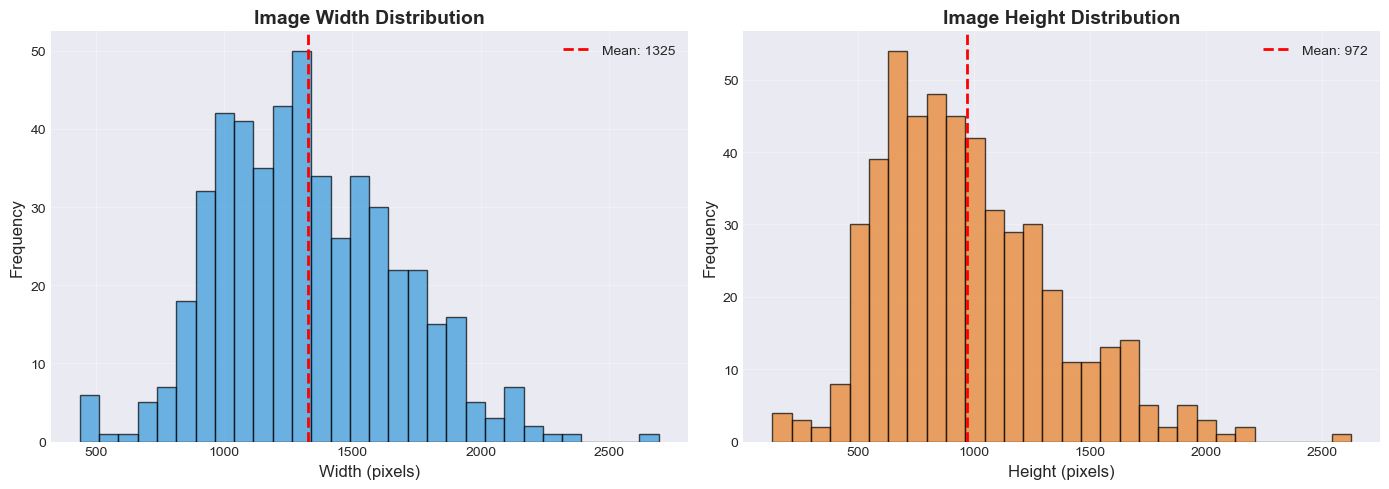


✅ Analysis complete!


In [7]:
"""
Analyze image dimensions
"""

print("="*60)
print("IMAGE DIMENSION ANALYSIS")
print("="*60)
print("\nAnalyzing sample of 500 images...")

# Sample images
sample_df = df.sample(n=500, random_state=42)

dimensions = []
for img_path in sample_df['path']:
    img = Image.open(img_path)
    dimensions.append(img.size)  # (width, height)

dimensions = np.array(dimensions)
widths = dimensions[:, 0]
heights = dimensions[:, 1]

# Statistics
print(f"\nWidth statistics:")
print(f"  Min: {widths.min()}")
print(f"  Max: {widths.max()}")
print(f"  Mean: {widths.mean():.1f}")
print(f"  Median: {np.median(widths):.1f}")
print(f"  Std: {widths.std():.1f}")

print(f"\nHeight statistics:")
print(f"  Min: {heights.min()}")
print(f"  Max: {heights.max()}")
print(f"  Mean: {heights.mean():.1f}")
print(f"  Median: {np.median(heights):.1f}")
print(f"  Std: {heights.std():.1f}")

# Most common dimensions
dim_counter = Counter([tuple(d) for d in dimensions])
print(f"\nMost common dimensions:")
for dim, count in dim_counter.most_common(5):
    print(f"  {dim[0]}×{dim[1]}: {count} images ({count/500*100:.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Width distribution
ax1 = axes[0]
ax1.hist(widths, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(widths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {widths.mean():.0f}')
ax1.set_title('Image Width Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Width (pixels)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Height distribution
ax2 = axes[1]
ax2.hist(heights, bins=30, color='#e67e22', alpha=0.7, edgecolor='black')
ax2.axvline(heights.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {heights.mean():.0f}')
ax2.set_title('Image Height Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Height (pixels)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/image_dimensions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Analysis complete!")

# Visualize Sample Images



- Display 5 random images from each class (`NORMAL` vs `PNEUMONIA`).  
- Helps verify image quality and correct labeling.  
- Saves visualization to `results/plots/sample_images.png`.


SAMPLE IMAGE VISUALIZATION


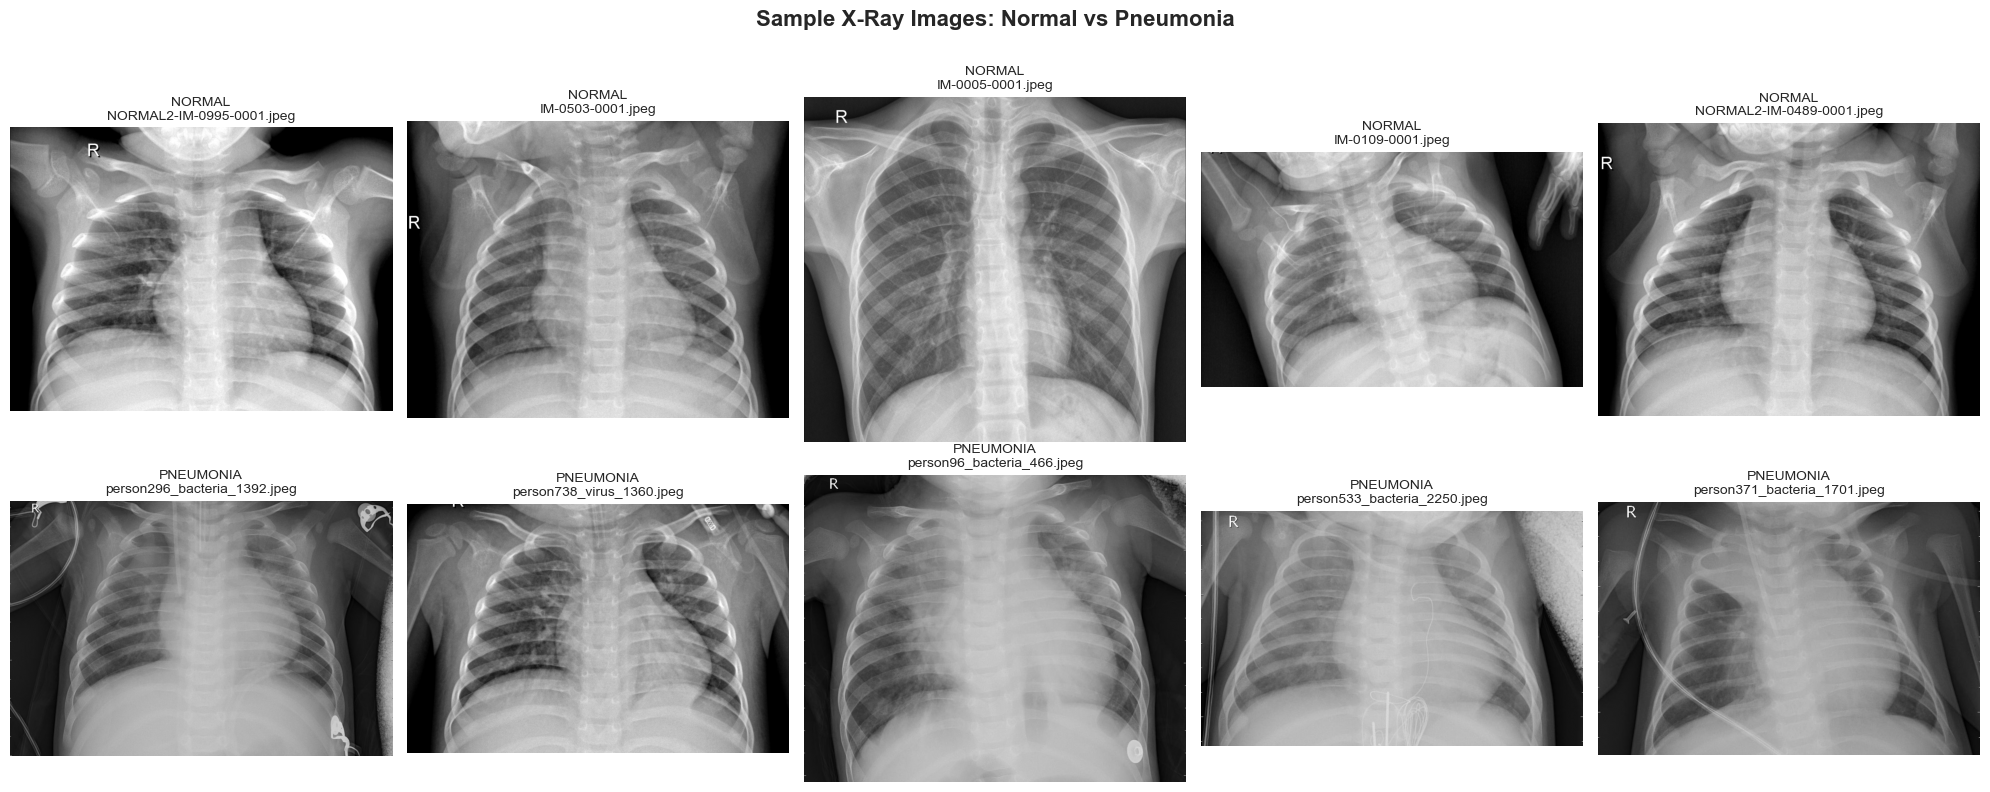


✅ Sample visualization complete!


In [9]:
"""
Visualize sample images from each class
"""

print("="*60)
print("SAMPLE IMAGE VISUALIZATION")
print("="*60)

# Select random samples
np.random.seed(42)
normal_samples = df[df['label'] == 'NORMAL'].sample(n=5)
pneumonia_samples = df[df['label'] == 'PNEUMONIA'].sample(n=5)

# Create figure
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot NORMAL images
for idx, (_, row) in enumerate(normal_samples.iterrows()):
    img = Image.open(row['path'])
    axes[0, idx].imshow(img, cmap='gray')
    axes[0, idx].set_title(f'NORMAL\n{Path(row["path"]).name}', fontsize=10)
    axes[0, idx].axis('off')

# Plot PNEUMONIA images
for idx, (_, row) in enumerate(pneumonia_samples.iterrows()):
    img = Image.open(row['path'])
    axes[1, idx].imshow(img, cmap='gray')
    axes[1, idx].set_title(f'PNEUMONIA\n{Path(row["path"]).name}', fontsize=10)
    axes[1, idx].axis('off')

plt.suptitle('Sample X-Ray Images: Normal vs Pneumonia', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/plots/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Sample visualization complete!")

# Pixel Intensity Analysis


- Sample 100 images per class (`NORMAL` and `PNEUMONIA`).  
- Compute mean and standard deviation of pixel intensities for each image.  
- Compare brightness and contrast distributions between classes using histograms.  
- Helps identify preprocessing requirements like normalization or contrast adjustment.


PIXEL INTENSITY ANALYSIS

Analyzing 100 images per class...

NORMAL images:
  Mean pixel intensity: 124.56 ± 12.58
  Std pixel intensity: 61.58 ± 5.75

PNEUMONIA images:
  Mean pixel intensity: 121.11 ± 20.03
  Std pixel intensity: 55.20 ± 9.50


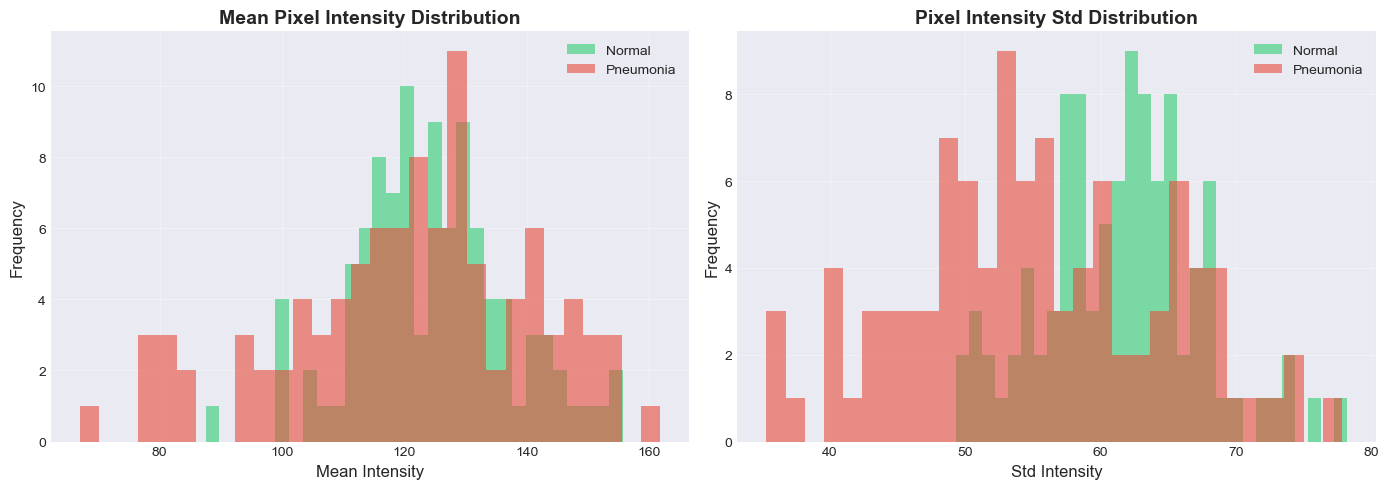


✅ Pixel analysis complete!


In [10]:
"""
Analyze pixel intensity distributions
"""

print("="*60)
print("PIXEL INTENSITY ANALYSIS")
print("="*60)

# Sample images for analysis
normal_sample = df[df['label'] == 'NORMAL'].sample(n=100, random_state=42)
pneumonia_sample = df[df['label'] == 'PNEUMONIA'].sample(n=100, random_state=42)

def get_pixel_stats(image_paths):
    """Calculate pixel intensity statistics"""
    means = []
    stds = []
    
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))  # Resize for consistency
        means.append(img.mean())
        stds.append(img.std())
    
    return np.array(means), np.array(stds)

print("\nAnalyzing 100 images per class...")

normal_means, normal_stds = get_pixel_stats(normal_sample['path'].tolist())
pneumonia_means, pneumonia_stds = get_pixel_stats(pneumonia_sample['path'].tolist())

print(f"\nNORMAL images:")
print(f"  Mean pixel intensity: {normal_means.mean():.2f} ± {normal_means.std():.2f}")
print(f"  Std pixel intensity: {normal_stds.mean():.2f} ± {normal_stds.std():.2f}")

print(f"\nPNEUMONIA images:")
print(f"  Mean pixel intensity: {pneumonia_means.mean():.2f} ± {pneumonia_means.std():.2f}")
print(f"  Std pixel intensity: {pneumonia_stds.mean():.2f} ± {pneumonia_stds.std():.2f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean intensity comparison
ax1 = axes[0]
ax1.hist(normal_means, bins=30, alpha=0.6, label='Normal', color='#2ecc71')
ax1.hist(pneumonia_means, bins=30, alpha=0.6, label='Pneumonia', color='#e74c3c')
ax1.set_title('Mean Pixel Intensity Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Mean Intensity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Std intensity comparison
ax2 = axes[1]
ax2.hist(normal_stds, bins=30, alpha=0.6, label='Normal', color='#2ecc71')
ax2.hist(pneumonia_stds, bins=30, alpha=0.6, label='Pneumonia', color='#e74c3c')
ax2.set_title('Pixel Intensity Std Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Std Intensity', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/pixel_intensity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Pixel analysis complete!")

# Key Findings Summary

In [11]:
"""
Summary of EDA findings
"""

print("\n" + "="*60)
print("EDA SUMMARY - KEY FINDINGS")
print("="*60)

print("""
1. DATASET SIZE:
   - Total images: 5,856
   - Training: 5,216 (89%)
   - Testing: 624 (11%)
   - Validation: 16 (0.3%) ⚠️ TOO SMALL - needs re-splitting

2. CLASS IMBALANCE:
   - Normal: 1,583 (27%)
   - Pneumonia: 4,273 (73%)
   - Imbalance ratio: 2.7:1 (moderate)
   - Action needed: Weighted loss or balanced sampling

3. IMAGE DIMENSIONS:
   - Highly variable sizes (400×400 to 2900×2900)
   - Most common: ~1000×1000 pixels
   - Action needed: Resize to 224×224 (ResNet) / 380×380 (EfficientNet)

4. PIXEL INTENSITY:
   - Normal images: Slightly darker (lower mean intensity)
   - Pneumonia images: Slightly brighter (higher mean intensity)
   - Good separability indicator

5. NEXT STEPS:
   ✅ Re-split dataset (proper train/val/test)
   ✅ Build data preprocessing pipeline
   ✅ Implement data augmentation
   ✅ Create PyTorch DataLoaders
""")

print("="*60)
print("✅ EDA COMPLETE!")
print("="*60)


EDA SUMMARY - KEY FINDINGS

1. DATASET SIZE:
   - Total images: 5,856
   - Training: 5,216 (89%)
   - Testing: 624 (11%)
   - Validation: 16 (0.3%) ⚠️ TOO SMALL - needs re-splitting

2. CLASS IMBALANCE:
   - Normal: 1,583 (27%)
   - Pneumonia: 4,273 (73%)
   - Imbalance ratio: 2.7:1 (moderate)
   - Action needed: Weighted loss or balanced sampling

3. IMAGE DIMENSIONS:
   - Highly variable sizes (400×400 to 2900×2900)
   - Most common: ~1000×1000 pixels
   - Action needed: Resize to 224×224 (ResNet) / 380×380 (EfficientNet)

4. PIXEL INTENSITY:
   - Normal images: Slightly darker (lower mean intensity)
   - Pneumonia images: Slightly brighter (higher mean intensity)
   - Good separability indicator

5. NEXT STEPS:
   ✅ Re-split dataset (proper train/val/test)
   ✅ Build data preprocessing pipeline
   ✅ Implement data augmentation
   ✅ Create PyTorch DataLoaders

✅ EDA COMPLETE!


# Save EDA Report

In [12]:
"""
Save EDA summary to file
"""

# Create summary dataframe
summary = {
    'Metric': [
        'Total Images',
        'Normal Images',
        'Pneumonia Images',
        'Imbalance Ratio',
        'Train Images',
        'Test Images',
        'Val Images',
        'Avg Image Width',
        'Avg Image Height',
        'Normal Mean Intensity',
        'Pneumonia Mean Intensity'
    ],
    'Value': [
        len(df),
        len(df[df['label'] == 'NORMAL']),
        len(df[df['label'] == 'PNEUMONIA']),
        f"{class_counts['PNEUMONIA']/class_counts['NORMAL']:.2f}:1",
        len(train_df),
        len(test_df),
        len(val_df),
        f"{widths.mean():.0f}px",
        f"{heights.mean():.0f}px",
        f"{normal_means.mean():.2f}",
        f"{pneumonia_means.mean():.2f}"
    ]
}

summary_df = pd.DataFrame(summary)
summary_df.to_csv('../results/eda_summary.csv', index=False)

print("✅ EDA summary saved to: results/eda_summary.csv")
print("\nSummary:")
print(summary_df.to_string(index=False))

✅ EDA summary saved to: results/eda_summary.csv

Summary:
                  Metric  Value
            Total Images   5856
           Normal Images   1583
        Pneumonia Images   4273
         Imbalance Ratio 2.70:1
            Train Images   5216
             Test Images    624
              Val Images     16
         Avg Image Width 1325px
        Avg Image Height  972px
   Normal Mean Intensity 124.56
Pneumonia Mean Intensity 121.11
